In [57]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import requests
import zipfile
import io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

data_url = 'https://github.com/Griselia23/wastemanagementapk/raw/main/ML/dataset/trash.zip'

# Download dan extract data
response = requests.get(data_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall('trash_dataset')

data_dir = 'trash_dataset/dataset-resized'

In [58]:
def create_data_generators(data_dir, target_size, batch_size):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2
    )
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    return train_generator, validation_generator

In [59]:
# Define model architecture
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [60]:
# Define optimizer with reduced learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model with the defined optimizer
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
# Define number of epochs
epochs = 50

In [62]:
# Define callbacks
def define_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    return [early_stopping, reduce_lr]

In [63]:
# Define reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [65]:
# Define data augmentation generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [66]:
# Generate training data with data augmentation
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 2024 images belonging to 6 classes.


In [67]:
# Generate validation data with data augmentation
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 503 images belonging to 6 classes.


In [68]:
# Train the model with early stopping and reduce learning rate on plateau
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4511 - loss: 1.3673 - val_accuracy: 0.4187 - val_loss: 1.4591 - learning_rate: 1.0000e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4375 - loss: 1.4744 - val_accuracy: 0.4783 - val_loss: 1.3209 - learning_rate: 1.0000e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4601 - loss: 1.3523 - val_accuracy: 0.4437 - val_loss: 1.4507 - learning_rate: 1.0000e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4062 - loss: 1.3167 - val_accuracy: 0.3043 - val_loss: 1.6234 - learning_rate: 1.0000e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.4659 - loss: 1.3414 - val_accuracy: 0.4313 - val_loss: 1.4445 - learning_rate: 1.0000e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3438 - loss: 1.4309 - val_accuracy: 0.4783 - val_loss: 1.3042 - learning_rate: 1.0000e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.4806 - l

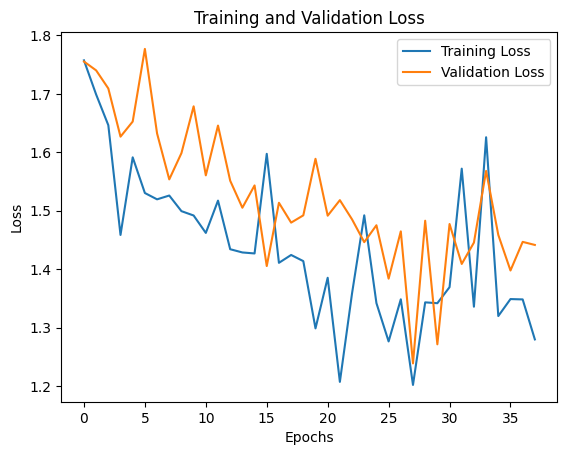

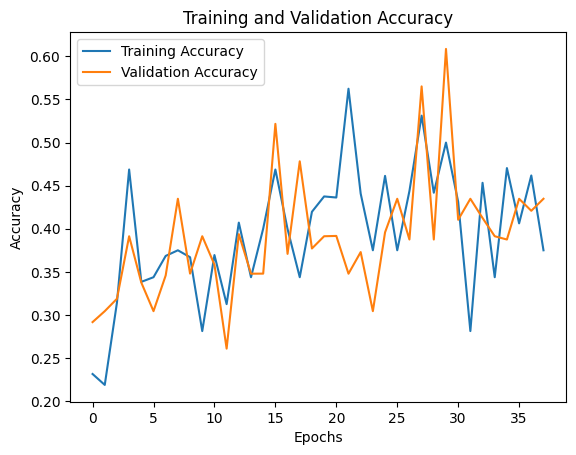

In [54]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
//save model with .tflife